# 1B ANOVA

## The Dataset

First, we have to load the dataset. Shown below are the first five rows:

In [1]:
import pandas as pd
from IPython.display import display, HTML

df = pd.read_csv('plantgrowth.csv')
display(df.head().style.hide(axis="index"))

weight,group
4.170000,ctrl
5.580000,ctrl
5.180000,ctrl
6.110000,ctrl
4.500000,ctrl


## Null and alternative hypothesis

The null hypothesis for a one-way analysis of variance is:

\$ H_0 \$: all group population means are equal (i.e., \$ \mu_1 = \mu_2 = \mu_3 = ... = \mu_k \$)

where \$ \mu \$ = population mean and \$ k \$ = number of groups.

\$ H_A \$: at least one group population mean is different (i.e., they are not all equal)

## Checking of Assumptions

### Assumption #1: You have one dependent variable that is measured at the continuous level.

**Remark.** The dependent variable is called 'weight' and is continuous level.

### Assumption #2: You have one independent variable that consists of two categorical, independent groups.

**Remark.** The independent variable is 'group' which is categorized into independent groups: ctrl, trt1, trt2.

### Assumption #3: You should have independence of observations.

**Remark.** The observations in each group of the independent variable or between the groups themselves do not affect one another. Since they are not related, then the observations are independent.

### Assumption #4: There should be no significant outliers in the three or more groups of your independent variable in terms of the dependent variable.

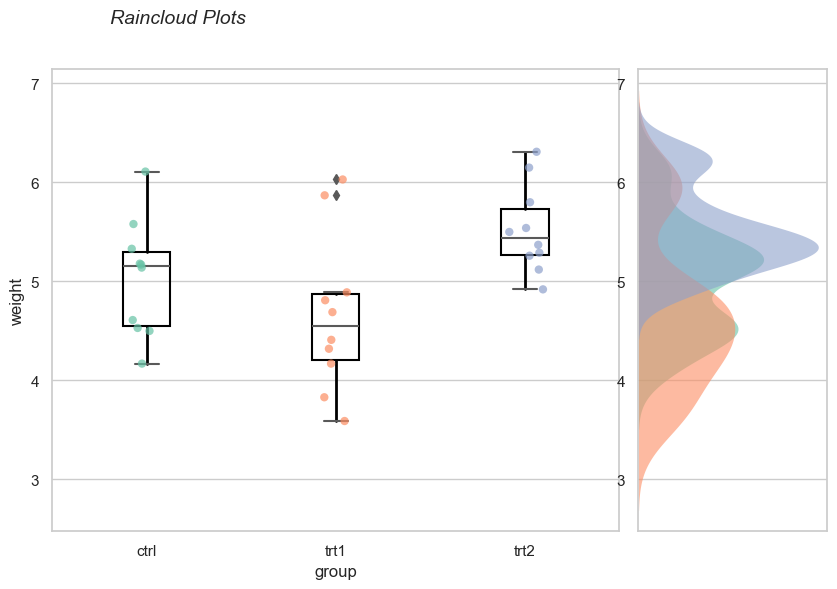

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")

fig = plt.figure(figsize=(10, 6))
grid = plt.GridSpec(1, 2, width_ratios=[3, 1], wspace=0.05)
ax_main = fig.add_subplot(grid[0])

sns.boxplot(x="group", y="weight", data=df, palette="Set2", width=0.25, showcaps=True, 
            boxprops={'facecolor':'None', 'edgecolor':'black'}, showfliers=True, 
            whiskerprops={'linewidth':2, 'color': 'black'}, ax=ax_main)
sns.stripplot(x="group", y="weight", data=df, palette="Set2", jitter=True, dodge=True, 
              size=6, ax=ax_main, alpha=0.7)

ax_kde = fig.add_subplot(grid[1], sharey=ax_main)

for i, group_type in enumerate(df["group"].unique()):
    subset = df[df['group'] == group_type]
    sns.kdeplot(data=subset, y="weight", ax=ax_kde, bw_adjust=0.6, fill=True, 
                color=sns.color_palette("Set2")[i], alpha=0.6, linewidth=0)

ax_kde.get_xaxis().set_visible(False)
ax_kde.set_ylabel('')
plt.suptitle('Raincloud Plots', fontsize=14, style='italic', x=0.25)
plt.show()

**Remark.** As observed from the boxplots, there are significant outliers in treatment 1. However, they are legitimate data entries and did not affect the results of the test so they are kept.

### Assumption #5: Your dependent variable should be approximately normally distributed for each group of the independent variable.

In [12]:
from scipy import stats
from scipy.stats import skew, kurtosis

def skew_sde(x):
    n = len(x)
    if n < 3:
        return np.nan
    return np.sqrt(6 * n * (n-1) / ((n-2) * (n+1) * (n+3)))

def kurt_sde(x):
    n = len(x)
    if n < 4:
        return np.nan
    return np.sqrt(24 * n * (n-1)**2 / ((n-3) * (n-2) * (n+3) * (n+5)))

group_stats = []

for group_name, group_data in df.groupby('group'):
    weight = group_data['weight']
    
    count = weight.count()
    mean = weight.mean()
    missing = weight.isnull().sum()
    std_dev = weight.std()
    skewness = skew(weight)
    std_error_skew = skew_sde(weight)
    kurt = kurtosis(weight)
    std_error_kurt = kurt_sde(weight)
    shapiro, p_shapiro = stats.shapiro(weight)
    
    group_stats.append({
        'Group': group_name,
        'Valid': count,
        'Missing': missing,
        'Mean': mean,
        'Std. Deviation': std_dev,
        'Skewness': skewness,
        'Std. Error of Skewness': std_error_skew,
        'Kurtosis': kurt,
        'Std. Error of Kurtosis': std_error_kurt,
        'Shapiro-Wilk': shapiro,
        'P-value of Shapiro-Wilk': p_shapiro,
    })

final_table = pd.DataFrame(group_stats).set_index('Group')
final_table = final_table.map(lambda x: f'{x:.3f}' if isinstance(x, float) else x).transpose()

title_stats = '<h4 style="text-align: left;">Descriptive Statistics by Group</h4>'
display(HTML(title_stats))
display(final_table)

Group,ctrl,trt1,trt2
Valid,10,10,10
Missing,0,0,0
Mean,5.032,4.661,5.526
Std. Deviation,0.583,0.794,0.443
Skewness,0.271,0.556,0.568
Std. Error of Skewness,0.687,0.687,0.687
Kurtosis,-0.675,-0.660,-0.729
Std. Error of Kurtosis,1.334,1.334,1.334
Shapiro-Wilk,0.957,0.930,0.941
P-value of Shapiro-Wilk,0.747,0.452,0.564


**Remark.** Since \$ p > 0.05 \$ by the Shapiro-Wilk's test in all 'group', then the variable 'weight' is approximately normally distributed for each of them.

### Assumption #6. You have homogeneity of variances (i.e., the variance of the dependent variable is equal in each group of your independent variable).

In [21]:
ctrl_df = df[df['group'] == 'ctrl']['weight']
trt1_df = df[df['group'] == 'trt1']['weight']
trt2_df = df[df['group'] == 'trt2']['weight']

stat_levene, p_levene = stats.levene(ctrl_df, trt1_df, trt2_df)

levene_df = pd.DataFrame({
    'F': [stat_levene],
    'df1': [3-1],
    'df2': [30-3],
    'p': [p_levene]
})

levene_df['F'] = levene_df['F'].round(3)
levene_df['p'] = levene_df['p'].round(3)

title_levene = '<h4 style="text-align: left;">Test for Equality of Variances (Levene\'s)</h4>'
display(HTML(title_levene))
display(levene_df.style.hide(axis="index"))

F,df1,df2,p
1.119000,2,27,0.341000


**Remark.** Since \$ p = 0.341 > 0.05 \$ by the Levene's test, then there was a homogeneity of variances of 'weight' for all 'group.'

## Computation

In [17]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('weight ~ group', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_table = anova_table.rename(columns={
    'sum_sq': 'Type III Sum of Squares',
    'df': 'df',
    'F': 'F',
    'PR(>F)': 'p'
})

anova_table['Mean Square'] = anova_table['Type III Sum of Squares'] / anova_table['df']
anova_table['η²p'] = anova_table.loc['group', 'Type III Sum of Squares'] / (anova_table.loc['Residual', 'Type III Sum of Squares'] + anova_table.loc['group', 'Type III Sum of Squares'])

anova_table = anova_table.drop('Intercept', errors='ignore')
anova_table.loc['Residual', ['F', 'p', 'η²p']] = None
anova_table = anova_table[['Type III Sum of Squares', 'df', 'Mean Square', 'F', 'p', 'η²p']]

anova_table = anova_table.style.format({
    'df': '{:.0f}',
    'p': '{:.3f}',
    'F': '{:.3f}',
    'η²p': '{:.2f}'
})

title_anova = '<h4 style="text-align: left;">ANOVA - weight</h4>'
display(HTML(title_anova))
anova_table

,Type III Sum of Squares,df,Mean Square,F,p,η²p
group,3.766340,2,1.883170,4.846,0.016,0.26
Residual,10.492090,27,0.388596,nan,nan,nan


In [6]:
describe_stats = []

for group_name, group_data in df.groupby('group'):
    weight = group_data['weight']

    mean = weight.mean()
    std_dev = weight.std()
    count = weight.count()
    
    describe_stats.append({
        'Group': group_name,
        'Mean': mean,
        'SD': std_dev,
        'N': count,
    })

describe_table = pd.DataFrame(describe_stats).set_index('Group')

describe_table = describe_table.style.format({
    'Mean': '{:.3f}',
    'SD': '{:.3f}',
})

title_describe = '<h4 style="text-align: left;">Descriptives - weight</h4>'
display(HTML(title_describe))
display(describe_table)

,Mean,SD,N
Group,,,
ctrl,5.032,0.583,10
trt1,4.661,0.794,10
trt2,5.526,0.443,10


In [7]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=df['weight'], groups=df['group'], alpha=0.05)
tukey_results = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])

tukey_results['SE'] = np.sqrt((tukey_results['meandiff'] ** 2) / len(df))
tukey_results['t'] = tukey_results['meandiff'] / tukey_results['SE']

tukey_results.rename(columns={
    'group1': 'Group 1',
    'group2': 'Group 2',
    'meandiff': 'Mean Difference',
    'lower': 'Lower CI',
    'upper': 'Upper CI',
    'p-adj': 'p_tukey'
}, inplace=True)

tukey_results = tukey_results[['Group 1', 'Group 2', 'Mean Difference', 'Lower CI', 'Upper CI', 'SE', 't', 'p_tukey']]
title_posthoc = '<h4 style="text-align: left;">Post Hoc Comparisons - Group</h4>'
title_ci = '<h5 style="text-align: left;">95% CI for Mean Difference</h4>'

display(HTML(title_posthoc))
display(HTML(title_ci))
display(tukey_results.style.hide(axis="index"))

Group 1,Group 2,Mean Difference,Lower CI,Upper CI,SE,t,p_tukey
ctrl,trt1,-0.371000,-1.062200,0.320200,0.067735,-5.477226,0.390900
ctrl,trt2,0.494000,-0.197200,1.185200,0.090192,5.477226,0.198000
trt1,trt2,0.865000,0.173800,1.556200,0.157927,5.477226,0.012000


## Reporting

A one-way ANOVA was conducted to determine if plant weight was different across different treatment groups. Plants were classified into three groups: control (n = 10), treatment 1 (n = 10), and treatment 2 (n = 10). There were outliers as assessed by visual inspection of the boxplots, but the results were not affected by these; data was normally distributed for each group, as assessed by Shapiro-Wilk test (p > 0.05); and there was homogeneity of variances, as assessed by Levene's test of homogeneity of variances (p = .341). Data is presented as mean ± standard deviation. Plant weight was statistically significantly different between the different treatment groups, F(2, 27) = 4.85, p = 0.016, η²p = 0.26. Plant weight increased from treatment 1 (M = 4.661, SD = 0.794) to the control group (M = 5.032, SD = 0.583) and treatment 2 (M = 5.526, SD = 0.443) groups, in that order. Note that not only was treatment 1 the least effective, but it also decreased plant growth compared to the control group.

Tukey post hoc analysis revealed that the mean increase from treatment 1 to treatment 2 (0.865, 95% CI [0.174, 1.556]) was statistically significant (p = 0.012), but no other group differences were statistically significant.